In [1]:
import pandas as pd
from konlpy.tag import Okt
from tqdm import tqdm


In [2]:
# 파일 불러오기
df = pd.read_csv('네이버리뷰_전처리.csv')

# 리뷰 컬럼 확인
print(df['리뷰'].head())


0    친구가 찻집갈까? 했는데, 차는 딱히 땡기지 않았지만영종도는 처음이라 흔쾌히 따라온...
1    오랜만에 차덕분에 왔습니다.차덕분은 여러가지 차와 음료, 커피, 아이스크림, 다과 ...
2    인천 영종도에 위치한 티하우스 '차덕분'재작년부터 방문하고 싶었던 곳이었으며, 호텔...
3    남편이 어렸을 때부터 자주 다니던 곳이라고 해서 공휴일에 일찍 일어나서 왔어요 일찍...
4    리뷰는 처음 남기지만 여러번 재방문한 차덕분입니다 :)오늘의차(모리화차 냉차)와 오...
Name: 리뷰, dtype: object


In [3]:
okt = Okt()

In [4]:
# 형태소 분석 결과를 저장할 리스트
pos_results = []

# 결측값 제거
texts = df['리뷰'].dropna()

# tqdm으로 진행률 표시
for review in tqdm(texts):
    try:
        pos = okt.pos(str(review))  # 형태소 분석 + 품사 태깅
        pos_results.append(pos)
    except:
        pos_results.append([])  # 오류 발생 시 빈 리스트 처리

100%|████████████████████████████████████| 13709/13709 [00:28<00:00, 479.48it/s]


In [5]:
# 형태소 분석 결과를 Series로 변환한 후 원본 df에 병합
df['형태소_분석'] = pd.Series(pos_results, index=texts.index)

In [6]:
# 일부 확인
df[['리뷰', '형태소_분석']].head()

,리뷰,형태소_분석
0,"친구가 찻집갈까? 했는데, 차는 딱히 땡기지 않았지만영종도는 처음이라 흔쾌히 따라온...","[(친구, Noun), (가, Josa), (찻집, Noun), (갈까, Verb)..."
1,"오랜만에 차덕분에 왔습니다.차덕분은 여러가지 차와 음료, 커피, 아이스크림, 다과 ...","[(오랜, Modifier), (만, Noun), (에, Josa), (차, Nou..."
2,"인천 영종도에 위치한 티하우스 '차덕분'재작년부터 방문하고 싶었던 곳이었으며, 호텔...","[(인천, Noun), (영종도, Noun), (에, Josa), (위치, Noun..."
3,남편이 어렸을 때부터 자주 다니던 곳이라고 해서 공휴일에 일찍 일어나서 왔어요 일찍...,"[(남편, Noun), (이, Josa), (어렸을, Verb), (때, Noun)..."
4,리뷰는 처음 남기지만 여러번 재방문한 차덕분입니다 :)오늘의차(모리화차 냉차)와 오...,"[(리뷰, Noun), (는, Josa), (처음, Noun), (남기지만, Ver..."


### 형용사 감성분석

In [8]:
#형용사추출
adjectives = []

for pos_list in df['형태소_분석'].dropna():
    for word, tag in pos_list:
        if tag == 'Adjective':
            adjectives.append(word)


In [9]:
#감성분석
import json

with open('data/SentiWord_info.json', 'r', encoding='utf-8') as f:
    senti_data = json.load(f)

# 문자열 형태의 감성 점수를 정수로 변환
sentiment_dict = {}

for item in senti_data:
    word = item['word']
    polarity_str = item['polarity']

    try:
        score = int(polarity_str)
        if score != 0:  # 중립은 제외
            sentiment_dict[word] = score
    except ValueError:
        continue  # 혹시 숫자가 아닌 값이 들어있는 경우 대비

In [10]:
from soynlp.tokenizer import LTokenizer

tokenizer = LTokenizer(scores={w: abs(s) for w, s in sentiment_dict.items()})

def score_sentiment(text):
    if pd.isna(text):
        return 0
    tokens = tokenizer.tokenize(str(text))
    return sum([sentiment_dict.get(token, 0) for token in tokens])

# 감성 점수 및 라벨
df['감성점수'] = df['리뷰'].apply(score_sentiment)
df['감성라벨'] = df['감성점수'].apply(
    lambda x: '긍정' if x > 0 else ('부정' if x < 0 else '중립')
)

# 결과 확인
print(df['감성라벨'].value_counts())

감성라벨
긍정    8557
중립    4382
부정     770
Name: count, dtype: int64


In [11]:
# 긍정/부정 리뷰의 형태소 분석 결과만 선택
pos_morphs = df[df['감성라벨'] == '긍정']['형태소_분석'].dropna()
neg_morphs = df[df['감성라벨'] == '부정']['형태소_분석'].dropna()

In [12]:
# 긍/부정 필터링
pos_adjs = []
neg_adjs = []

# 긍정 리뷰
for morphs in pos_morphs:
    for word, tag in morphs:
        if tag == 'Adjective':
            pos_adjs.append(word)

# 부정 리뷰
for morphs in neg_morphs:
    for word, tag in morphs:
        if tag == 'Adjective':
            neg_adjs.append(word)


In [161]:
#불용어 제거
stop_pos_adjs = {'좋음','좋았고','좋아서','좋습니다', '좋네요', '좋을', '좋게', '좋아했어요', '좋은데', '아쉬웠어요', '좋다고', '좋다', '좋을것', '입니다','있어서','같아요','있는','있고','있어','있어요','있습니다','그런지','있었어요','같습니다','좋아요','좋은','좋고','좋았어요','좋았습니다'}
stop_neg_adjs = {'많았습니다','맛있어요','이쁘고','깔끔하고','다양한','괜찮았어요','아니고','상당히','넓어서','넓은','많은','이런','야할듯', '많아서', '많아', '많은데', '많아요', '많았어요', '많고', '있다', '좋은데', '있는데', '굉장히', '좋겠어요','많아서','좋네요','같네요','있었습니다','입니다','있어서','같아요','있는','있고','있어','있어요','있습니다','그런지','있었어요','같습니다','좋았어요','좋았습니다','좋고','같은','좋았고', '좋아요','좋았는데','좋은','좋습니다'}

# 길이 > 1 + 불용어 제거
filtered_pos_adjs = [a for a in pos_adjs if a not in stop_pos_adjs and len(a) > 1]
filtered_neg_adjs = [a for a in neg_adjs if a not in stop_neg_adjs and len(a) > 1]

In [163]:
from collections import Counter

top_pos_adjs = Counter(filtered_pos_adjs).most_common(30)
top_neg_adjs = Counter(filtered_neg_adjs).most_common(30)


In [165]:
top_pos_adjs

[('깨끗하고', 540),
 ('많아서', 245),
 ('많고', 223),
 ('넓고', 202),
 ('즐거운', 166),
 ('깔끔하고', 162),
 ('맛있고', 160),
 ('맛있어요', 155),
 ('편하게', 149),
 ('다양한', 141),
 ('친절하고', 141),
 ('만족합니다', 117),
 ('따뜻한', 116),
 ('예쁘고', 116),
 ('친절하시고', 111),
 ('없어서', 105),
 ('멋진', 102),
 ('즐겁게', 94),
 ('행복한', 94),
 ('조용하고', 90),
 ('많아', 90),
 ('많아요', 89),
 ('있는데', 85),
 ('친절해요', 83),
 ('예쁜', 82),
 ('넓어서', 82),
 ('친절하게', 81),
 ('같은', 80),
 ('없고', 80),
 ('시원하고', 80)]

In [167]:
top_neg_adjs

[('없어서', 58),
 ('비싼', 44),
 ('없고', 40),
 ('추워서', 28),
 ('불편했어요', 27),
 ('없어요', 23),
 ('없는', 21),
 ('없다', 18),
 ('안되고', 17),
 ('더워서', 16),
 ('있지만', 13),
 ('힘들었어요', 12),
 ('아쉽네요', 12),
 ('없음', 11),
 ('힘들고', 11),
 ('작은', 11),
 ('힘들어요', 10),
 ('힘들었지만', 10),
 ('시끄럽고', 10),
 ('아쉬웠어요', 10),
 ('안되서', 10),
 ('힘들', 9),
 ('비싸고', 9),
 ('넓고', 9),
 ('지저분하고', 9),
 ('심하게', 9),
 ('조용히', 9),
 ('높아서', 9),
 ('좁고', 8),
 ('없었어요', 8)]

In [169]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# 예시: 리스트가 아니라 Counter로 만들어야 함
# 잘못된 경우: top_pos_adjs = Counter(filtered_pos_adjs).most_common(100) ← 이건 list임
# 올바른 경우:
wc_pos_adjs = Counter(filtered_pos_adjs)
wc_neg_adjs = Counter(filtered_neg_adjs)


In [191]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 경로 설정 (Mac 기준, Windows일 경우 경로 다름)
font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"

# font_path = 'C:/Windows/Fonts/malgun.ttf'  # Windows 예시

# 워드클라우드 생성 함수
def create_wordcloud(counter_obj, title, color='black'):
    wordcloud = WordCloud(
        font_path=font_path,
        background_color='white',
        colormap='cool' if color == 'pos' else 'Reds',
        width=800,
        height=400
    ).generate_from_frequencies(counter_obj)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()


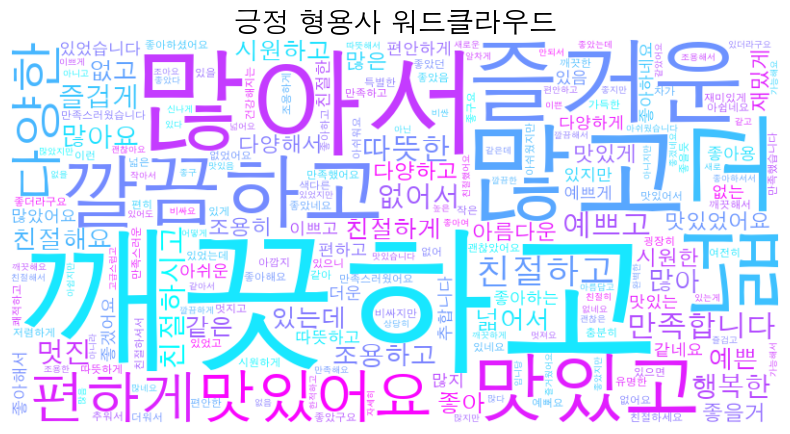

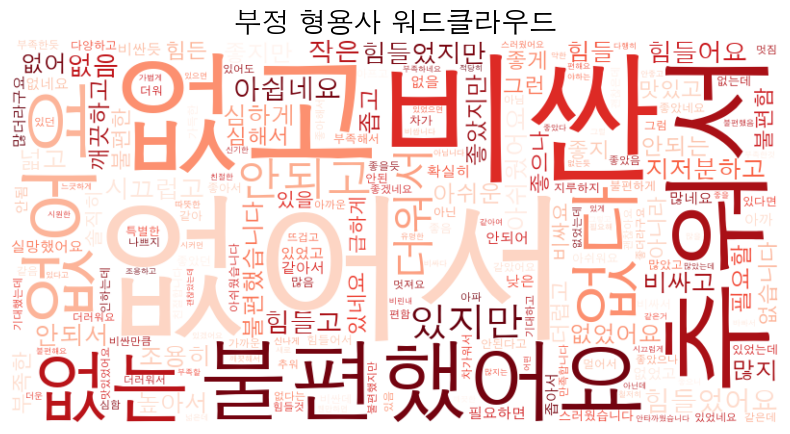

In [193]:
# 긍정 형용사 워드클라우드
create_wordcloud(wc_pos_adjs, '긍정 형용사 워드클라우드', color='pos')

# 부정 형용사 워드클라우드
create_wordcloud(wc_neg_adjs, '부정 형용사 워드클라우드', color='neg')
